## 7.2 새와 비행기를 구별하기

### 7.2.1 데이터셋 구축

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
from torchvision import datasets, transforms

In [4]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), 
                             (0.2470, 0.2435, 0.2616)),
    ])
)

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), 
                             (0.2470, 0.2435, 0.2616)),
    ])
)

In [7]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

### 7.2.2 완전 연결 모델

In [8]:
import torch.nn as nn

In [9]:
n_out = 2

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
)

### 7.2.3 분류기의 출력

### 7.2.4 출력을 확률로 표현하기

In [10]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [11]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [12]:
softmax(x).sum()

tensor(1.)

In [13]:
softmax = nn.Softmax(dim=1)

In [14]:
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [15]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


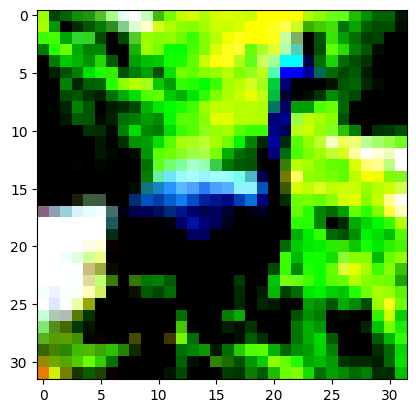

In [16]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [17]:
img_batch = img.view(-1).unsqueeze(0)

In [18]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [19]:
_, index = torch.max(out, dim=1)

index

tensor([1])

### 7.2.5 분류를 위한 손실값

In [24]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])

class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4, 2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [25]:
def mse(out):
    return ((out - truth)**2).sum(dim=1).mean()

mse(out)

tensor(0.1500)

In [27]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [28]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [29]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [31]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1])  # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6])  # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9])  # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [32]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [33]:
nll_comparison = torch.tensor([neg_log_likelihood(o)
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [34]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [36]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0 , 104.0]])

softmax(x)

tensor([[0., 1.]])

In [37]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [38]:
log_softmax(x)

tensor([[-104.,    0.]])

In [39]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [20]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1),
)

In [21]:
loss = nn.NLLLoss()

In [22]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

### 7.2.6 분류기 훈련

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

In [41]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1),
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch: %d, Loss: %f' % (epoch, float(loss)))

Epoch: 0, Loss: 8.307038
Epoch: 1, Loss: 5.457431
Epoch: 2, Loss: 3.882373
Epoch: 3, Loss: 3.154704
Epoch: 4, Loss: 11.443868
Epoch: 5, Loss: 7.831904
Epoch: 6, Loss: 0.055682
Epoch: 7, Loss: 7.118860
Epoch: 8, Loss: 6.412682
Epoch: 9, Loss: 5.462630
Epoch: 10, Loss: 6.324239
Epoch: 11, Loss: 8.132204
Epoch: 12, Loss: 4.478361
Epoch: 13, Loss: 0.397974
Epoch: 14, Loss: 3.924431
Epoch: 15, Loss: 6.191980
Epoch: 16, Loss: 4.834426
Epoch: 17, Loss: 6.948432
Epoch: 18, Loss: 0.884499
Epoch: 19, Loss: 10.726386
Epoch: 20, Loss: 8.787334
Epoch: 21, Loss: 5.266410
Epoch: 22, Loss: 7.096104
Epoch: 23, Loss: 4.407344
Epoch: 24, Loss: 6.470562
Epoch: 25, Loss: 10.756291
Epoch: 26, Loss: 16.045588
Epoch: 27, Loss: 13.241747
Epoch: 28, Loss: 8.135650
Epoch: 29, Loss: 9.221145
Epoch: 30, Loss: 11.256797
Epoch: 31, Loss: 13.286485
Epoch: 32, Loss: 14.590942
Epoch: 33, Loss: 19.243477
Epoch: 34, Loss: 7.613646
Epoch: 35, Loss: 8.939101
Epoch: 36, Loss: 5.921707
Epoch: 37, Loss: 7.737715
Epoch: 38, Lo

In [42]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1),
)

learning_rate= 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch: %d, Loss: %f' % (epoch, float(loss)))

Epoch: 0, Loss: 0.397572
Epoch: 1, Loss: 0.538591
Epoch: 2, Loss: 0.604014
Epoch: 3, Loss: 0.312301
Epoch: 4, Loss: 0.222018
Epoch: 5, Loss: 0.426519
Epoch: 6, Loss: 0.461691
Epoch: 7, Loss: 0.262630
Epoch: 8, Loss: 0.332231
Epoch: 9, Loss: 0.280448
Epoch: 10, Loss: 0.565670
Epoch: 11, Loss: 0.659396
Epoch: 12, Loss: 0.324872
Epoch: 13, Loss: 0.382447
Epoch: 14, Loss: 0.320156
Epoch: 15, Loss: 0.456478
Epoch: 16, Loss: 0.282852
Epoch: 17, Loss: 0.277185
Epoch: 18, Loss: 0.309715
Epoch: 19, Loss: 0.375523
Epoch: 20, Loss: 0.280217
Epoch: 21, Loss: 0.584804
Epoch: 22, Loss: 0.334413
Epoch: 23, Loss: 0.333861
Epoch: 24, Loss: 0.473030
Epoch: 25, Loss: 0.195316
Epoch: 26, Loss: 0.334505
Epoch: 27, Loss: 0.151914
Epoch: 28, Loss: 0.205874
Epoch: 29, Loss: 0.387692
Epoch: 30, Loss: 0.107604
Epoch: 31, Loss: 0.149629
Epoch: 32, Loss: 0.139355
Epoch: 33, Loss: 0.184131
Epoch: 34, Loss: 0.085184
Epoch: 35, Loss: 0.111466
Epoch: 36, Loss: 0.260271
Epoch: 37, Loss: 0.058575
Epoch: 38, Loss: 0.211

In [45]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print('Accuracy: %f' % (correct / total))

Accuracy: 0.998100


In [46]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print('Accuracy: %f' % (correct / total))

Accuracy: 0.824000


In [47]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1),
)

In [49]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

loss_fn = nn.CrossEntropyLoss()

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch: %d, Loss: %f' % (epoch, float(loss)))

Epoch: 0, Loss: 0.455609
Epoch: 1, Loss: 0.391482
Epoch: 2, Loss: 0.283724
Epoch: 3, Loss: 0.213154
Epoch: 4, Loss: 0.329904
Epoch: 5, Loss: 0.467958
Epoch: 6, Loss: 0.557676
Epoch: 7, Loss: 0.248211
Epoch: 8, Loss: 0.417725
Epoch: 9, Loss: 0.378215
Epoch: 10, Loss: 0.277747
Epoch: 11, Loss: 0.413051
Epoch: 12, Loss: 0.280609
Epoch: 13, Loss: 0.332915
Epoch: 14, Loss: 0.380871
Epoch: 15, Loss: 0.321482
Epoch: 16, Loss: 0.280717
Epoch: 17, Loss: 0.301373
Epoch: 18, Loss: 0.184985
Epoch: 19, Loss: 0.291908
Epoch: 20, Loss: 0.403512
Epoch: 21, Loss: 0.237246
Epoch: 22, Loss: 0.200415
Epoch: 23, Loss: 0.298543
Epoch: 24, Loss: 0.234256
Epoch: 25, Loss: 0.088164
Epoch: 26, Loss: 0.354694
Epoch: 27, Loss: 0.257752
Epoch: 28, Loss: 0.246270
Epoch: 29, Loss: 0.368417
Epoch: 30, Loss: 0.143550
Epoch: 31, Loss: 0.294702
Epoch: 32, Loss: 0.390204
Epoch: 33, Loss: 0.154977
Epoch: 34, Loss: 0.189191
Epoch: 35, Loss: 0.133256
Epoch: 36, Loss: 0.131026
Epoch: 37, Loss: 0.302202
Epoch: 38, Loss: 0.430

In [52]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print('Accuracy: %f' % (correct / total))

Accuracy: 1.000000


In [53]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print('Accuracy: %f' % (correct / total))

Accuracy: 0.804500


In [59]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [60]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [61]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1),
)

first_model_numel_list = [p.numel() for p in first_model.parameters() if p.requires_grad == True]
sum(first_model_numel_list), first_model_numel_list

(1574402, [1572864, 512, 1024, 2])

In [62]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [63]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [64]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

### 7.2.7 완전 연결의 한계

In [65]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [66]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [67]:
conv.bias.shape

torch.Size([16])

In [68]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [69]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


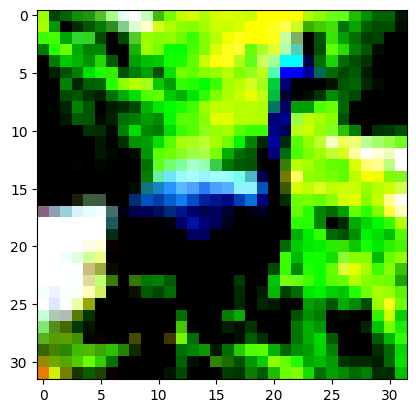

In [70]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

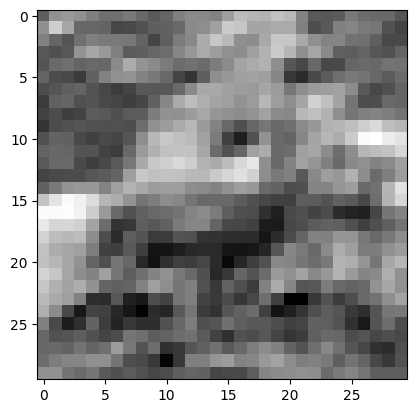

In [72]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [73]:
output.shape

torch.Size([1, 16, 30, 30])

In [74]:
conv = nn. Conv2d(3, 1, kernel_size=3, padding=1)

In [75]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [77]:
with torch.no_grad():
    conv.bias.zero_()

In [78]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

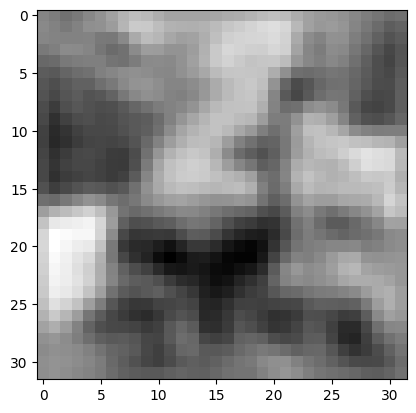

In [79]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [80]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

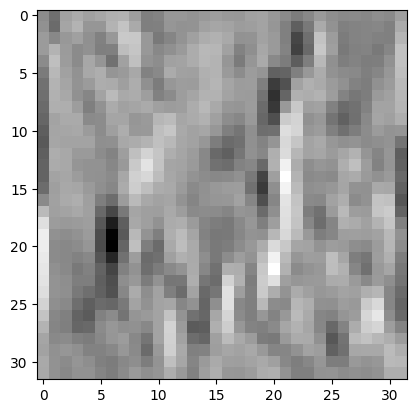

In [81]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [82]:
pool = nn.MaxPool2d(2)

In [83]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [84]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    ...
)

TypeError: ellipsis is not a Module subclass

In [86]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # WARNING: something missing here
    nn.Linear(512, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
)

In [87]:
sum([p.numel() for p in model.parameters()])

18090

In [88]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [91]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [92]:
model = Net()

sum([p.numel() for p in model.parameters()])

18090

In [93]:
import torch.nn.functional as F

In [94]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [95]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1864, 0.1183]], grad_fn=<AddmmBackward0>)

In [96]:
sum([p.numel() for p in model.parameters()])

18090

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch: %d, Loss: %f' % (epoch, float(loss)))

Epoch: 0, Loss: 0.439813
Epoch: 1, Loss: 0.360302
Epoch: 2, Loss: 0.495798
Epoch: 3, Loss: 0.568403
Epoch: 4, Loss: 0.608500
Epoch: 5, Loss: 0.157080
Epoch: 6, Loss: 0.214584
Epoch: 7, Loss: 0.733224
Epoch: 8, Loss: 0.269851
Epoch: 9, Loss: 0.539099
Epoch: 10, Loss: 0.323184
Epoch: 11, Loss: 0.294383
Epoch: 12, Loss: 0.364603
Epoch: 13, Loss: 0.259270
Epoch: 14, Loss: 0.331193
Epoch: 15, Loss: 0.227384
Epoch: 16, Loss: 0.495924
Epoch: 17, Loss: 0.321210
Epoch: 18, Loss: 0.823547
Epoch: 19, Loss: 0.315496
Epoch: 20, Loss: 0.184118
Epoch: 21, Loss: 0.338498
Epoch: 22, Loss: 0.252525
Epoch: 23, Loss: 0.240335
Epoch: 24, Loss: 0.200686
Epoch: 25, Loss: 0.150262
Epoch: 26, Loss: 0.143781
Epoch: 27, Loss: 0.322757
Epoch: 28, Loss: 0.659715
Epoch: 29, Loss: 0.185159
Epoch: 30, Loss: 0.286908
Epoch: 31, Loss: 0.367867
Epoch: 32, Loss: 0.409152
Epoch: 33, Loss: 0.264765
Epoch: 34, Loss: 0.139667
Epoch: 35, Loss: 0.167221
Epoch: 36, Loss: 0.350909
Epoch: 37, Loss: 0.309976
Epoch: 38, Loss: 0.483

In [106]:
len(cifar2_val) % 64

16

In [108]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print('Accuracy: %f' % (correct / total))

Accuracy: 0.888000
